In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
from pathlib import Path

In [2]:
# Dataset
DATASET_DIR = './multi-cancer'

# Image
H, W = 224, 224
MEAN = torch.tensor([0.5637, 0.5240, 0.6399])
STD = torch.tensor([0.1517, 0.1678, 0.1160])

# Training
BATCH_SIZE = 64

TRAIN_PHASE1 = False
TRAIN_PHASE2 = False
TRAIN_PHASE3 = False

PHASE1_EPOCHS = 20
PHASE2_EPOCHS = 30
PHASE3_EPOCHS = 5

PHASE1_PATIENCE = 5
PHASE2_PATIENCE = 7

CRITERION = nn.CrossEntropyLoss()

PHASE1_LR = 1e-3
PHASE2_LR = 5e-5
PHASE3_LR = 1e-5

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [5]:
# 修改後的資料載入
all_cancer_types = [d for d in os.listdir(DATASET_DIR) 
                    if os.path.isdir(os.path.join(DATASET_DIR, d))]

print(f"Found {len(all_cancer_types)} cancer types:", all_cancer_types)

image_paths = []
image_labels = []
class_names = []
class_to_idx = {}
class_counts = {}

current_label = 0

for cancer_type in sorted(all_cancer_types):
    cancer_dir = os.path.join(DATASET_DIR, cancer_type)
    classes = sorted([d for d in os.listdir(cancer_dir) 
                         if os.path.isdir(os.path.join(cancer_dir, d))])
    for class_name in classes:
        class_names.append(class_name)
        class_to_idx[class_name] = current_label
        class_counts[class_name] = 0
        
        class_dir = os.path.join(cancer_dir, class_name)
        for filename in os.listdir(class_dir):
            path = os.path.join(class_dir, filename)
            if os.path.isfile(path):
                image_paths.append(path)
                image_labels.append(current_label)
                class_counts[class_name] += 1
        current_label += 1

print(f"\nTotal classes: {len(class_names)}")
print("Class names:", class_names)
print("\nClass distribution:")
for cls_name, count in class_counts.items():
    print(f"  {cls_name}: {count}")

Found 8 cancer types: ['ALL', 'Brain Cancer', 'Breast Cancer', 'Cervical Cancer', 'Kidney Cancer', 'Lung and Colon Cancer', 'Lymphoma', 'Oral Cancer']

Total classes: 26
Class names: ['all_benign', 'all_early', 'all_pre', 'all_pro', 'brain_glioma', 'brain_menin', 'brain_tumor', 'breast_benign', 'breast_malignant', 'cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi', 'kidney_normal', 'kidney_tumor', 'colon_aca', 'colon_bnt', 'lung_aca', 'lung_bnt', 'lung_scc', 'lymph_cll', 'lymph_fl', 'lymph_mcl', 'oral_normal', 'oral_scc']

Class distribution:
  all_benign: 5000
  all_early: 5000
  all_pre: 5000
  all_pro: 5000
  brain_glioma: 5000
  brain_menin: 5000
  brain_tumor: 5000
  breast_benign: 5000
  breast_malignant: 5000
  cervix_dyk: 5000
  cervix_koc: 5000
  cervix_mep: 5000
  cervix_pab: 5000
  cervix_sfi: 5000
  kidney_normal: 5000
  kidney_tumor: 5000
  colon_aca: 5000
  colon_bnt: 5000
  lung_aca: 5000
  lung_bnt: 5000
  lung_scc: 5000
  lymph_cll: 5000
  lymph_fl: 5

In [6]:
train_paths, temp_paths, train_labels, temp_labels = train_test_split(image_paths, image_labels, test_size=0.3, stratify=image_labels)
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.5, stratify=temp_labels)

print("Training size:", len(train_paths))
print("Validation size:", len(val_paths))
print("Testing size:", len(test_paths))

Training size: 91001
Validation size: 19500
Testing size: 19501


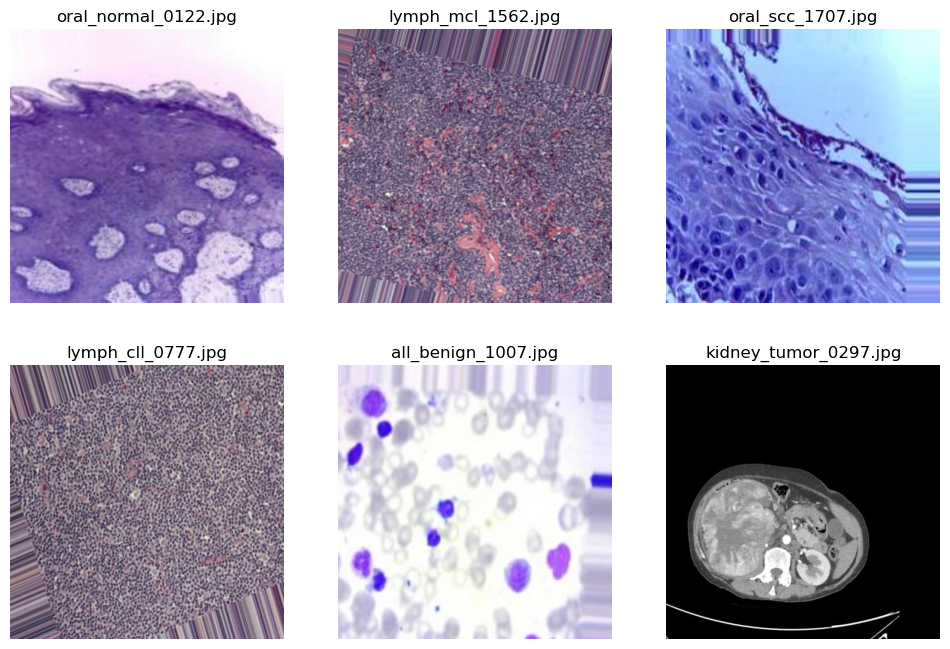

In [7]:
sample_images = random.sample(train_paths, 6)
plt.figure(figsize=(12, 8))

for i, img_path in enumerate(sample_images):
    img = Image.open(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(os.path.basename(img_path), fontsize=12)
    plt.axis('off')

plt.show()

In [8]:
# # Calculate Mean and Standard Deviation of the training set
# transform = transforms.Compose([
#     transforms.Resize((H, W)),
#     transforms.ToTensor()
# ])

# mean = 0.
# std = 0.
# n = 0

# for path in tqdm(train_paths):
#     img = Image.open(path).convert('RGB')
#     img = transform(img)  # shape: [3, H, W]
#     mean += img.mean(dim=[1,2])
#     std += img.std(dim=[1,2])
#     n += 1

# mean /= n
# std /= n

# print("Mean:", mean)
# print("Std:", std)

In [9]:
#Data augmentation 
train_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

val_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

test_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

In [10]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, image_labels, transform=None):
        self.image_paths = image_paths
        self.labels = image_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

train_dataset = ImageDataset(train_paths, train_labels, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 

val_dataset = ImageDataset(val_paths, val_labels, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False) 

test_dataset = ImageDataset(test_paths, test_labels, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    loop = tqdm(dataloader, desc="Training", leave=False)

    for images, labels in loop:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = images.size(0)
        total_loss += loss.item() * batch_size
        preds = outputs.argmax(1)
        total_correct += (preds == labels).sum().item()
        total_samples += batch_size

        current_loss = total_loss / total_samples
        current_acc = total_correct / total_samples
        loop.set_postfix(loss=current_loss, acc=current_acc)

    return total_loss / total_samples, total_correct / total_samples

In [12]:
@torch.no_grad()
def eval_one_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    loop = tqdm(dataloader, desc="Validating", leave=False)

    for images, labels in loop:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        loss = criterion(outputs, labels)

        batch_size = images.size(0)
        total_loss += loss.item() * batch_size
        preds = outputs.argmax(1)
        total_correct += (preds == labels).sum().item()
        total_samples += batch_size

        current_loss = total_loss / total_samples
        current_acc = total_correct / total_samples
        loop.set_postfix(loss=current_loss, acc=current_acc)

    return total_loss / total_samples, total_correct / total_samples

In [13]:
def save_checkpoint(model, optimizer, epoch, val_acc, train_losses, val_losses, save_path):
    save_path = Path(save_path)
    save_path.parent.mkdir(parents=True, exist_ok=True)

    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "val_acc": val_acc,
        "train_losses": train_losses,
        "val_losses": val_losses
    }, save_path)

    print(f"[Checkpoint Saved] epoch={epoch}, acc={val_acc:.4f} → {save_path}")

def load_checkpoint(model, optimizer, path, device):
    if not os.path.isfile(path):
        raise FileNotFoundError(f"No checkpoint found at '{path}'")

    ckpt = torch.load(path, map_location=device)

    model.load_state_dict(ckpt["model_state_dict"])

    if optimizer is not None:
        optimizer.load_state_dict(ckpt["optimizer_state_dict"])

    start_epoch = ckpt.get("epoch", 0)
    best_val_acc = ckpt.get("val_acc", 0.0)

    train_losses = ckpt.get("train_losses", [])
    val_losses = ckpt.get("val_losses", [])

    print(f"[Checkpoint Loaded] epoch={start_epoch}, best_acc={best_val_acc:.4f}")
    return model, optimizer, start_epoch, best_val_acc, train_losses, val_losses

In [27]:
@torch.no_grad()
def evaluate_on_test(model, test_loader, device, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []

    for images, labels in tqdm(test_loader, desc="Testing"):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy().tolist())
        all_labels.extend(labels.cpu().numpy().tolist())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    acc = (all_preds == all_labels).mean()
    print(f"\nTest Accuracy: {acc:.4f}")

    if class_names is None:
        class_names = ["normal", "SCC"]

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    n_classes = len(class_names)
    fig_size = max(12, n_classes * 0.6)

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(fig_size, fig_size))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=class_names,
                yticklabels=class_names,
                cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (Test Set)")

    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)

    plt.tight_layout()
    plt.show()

### Phase 1: Train with frozen backbone

In [15]:
NUM_CLASSES = len(class_names)
print(f"Number of classes: {NUM_CLASSES}")

weights = EfficientNet_B0_Weights.IMAGENET1K_V1
model = efficientnet_b0(weights=weights)

in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, NUM_CLASSES) # type: ignore

for param in model.features.parameters():
    param.requires_grad = False

model = model.to(device)

trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(trainable_params, lr=PHASE1_LR, weight_decay=1e-4)

Number of classes: 26


In [16]:
best_val_acc = 0.0

checkpoint_dir = Path('checkpoints') / 'All_Cancer' / 'phase1'
checkpoint_dir.mkdir(parents=True, exist_ok=True)
checkpoint_path = checkpoint_dir / "best_model.pth"

if TRAIN_PHASE1:
    train_losses = []
    val_losses = []
    start_epoch = 0
    patience_counter = 0

    for epoch in range(PHASE1_EPOCHS):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, CRITERION, device)
        val_loss, val_acc = eval_one_epoch(model, val_loader, CRITERION, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"[Epoch {epoch+1}/{PHASE1_EPOCHS}] "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            save_checkpoint(model, optimizer, epoch + 1, best_val_acc, train_losses, val_losses, checkpoint_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PHASE1_PATIENCE:
                print("Early stopping triggered.")
                break
else:
    model, optimizer, start_epoch, best_val_acc, train_losses, val_losses = load_checkpoint(model, optimizer, checkpoint_path, device)

[Checkpoint Loaded] epoch=19, best_acc=0.9437


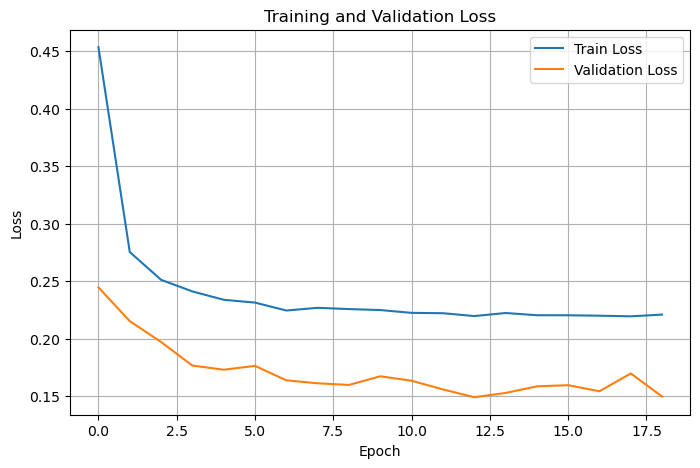

In [17]:
plt.figure(figsize=(8, 5)) 
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

### Phase 2: Fine-tune with partially unfrozen backbone

In [18]:
for param in model.features.parameters():
    param.requires_grad = False


num_blocks = len(model.features)
for idx in range(num_blocks - 3, num_blocks):
    for param in model.features[idx].parameters():
        param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

model = model.to(device)

trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(trainable_params, lr=PHASE2_LR, weight_decay=1e-4)

In [19]:
checkpoint_dir = Path('checkpoints') / 'All_Cancer' / 'phase2'
checkpoint_dir.mkdir(parents=True, exist_ok=True)
checkpoint_path = checkpoint_dir / "best_model.pth"

if TRAIN_PHASE2:
    train_losses = []
    val_losses = []
    val_accs = []
    best_val_acc = 0.0
    patience_counter = 0

    for epoch in range(PHASE2_EPOCHS):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, CRITERION, device)
        val_loss, val_acc = eval_one_epoch(model, val_loader, CRITERION, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"[Phase2 Epoch {epoch+1}/{PHASE2_EPOCHS}] "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            save_checkpoint(model, optimizer, epoch + 1, best_val_acc, train_losses, val_losses, checkpoint_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PHASE2_PATIENCE:
                print("Early stopping triggered.")
                break
else:
    model, optimizer, start_epoch, best_val_acc, train_losses, val_losses = load_checkpoint(model, optimizer, checkpoint_path, device)

[Checkpoint Loaded] epoch=27, best_acc=0.9989


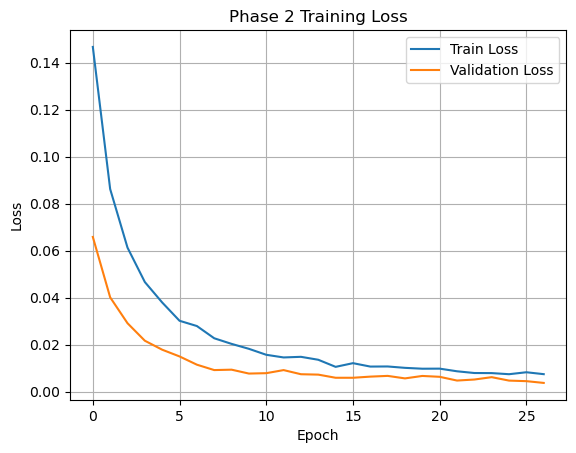

In [20]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Phase 2 Training Loss')
plt.legend()
plt.grid(True)
plt.show()

### Phase 3: Final training with combined data (train + val)

In [ ]:
# combined_dataset = ConcatDataset([train_dataset, val_dataset])
# combined_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# for param in model.parameters():
#     param.requires_grad = True

# trainable_params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.AdamW(trainable_params, lr=PHASE3_LR, weight_decay=1e-4)

In [23]:
# checkpoint_dir = Path('checkpoints') / 'All_Cancer' / 'phase3'
# checkpoint_dir.mkdir(parents=True, exist_ok=True)
# checkpoint_path = checkpoint_dir / "best_model.pth"

# if TRAIN_PHASE3:
#     combined_losses = []
#     test_losses = []
#     test_accs = []
#     best_test_acc = 0.0

#     for epoch in range(PHASE3_EPOCHS):
#         combined_loss, combined_acc = train_one_epoch(model, combined_loader, optimizer, CRITERION, device)
#         test_loss, test_acc = eval_one_epoch(model, test_loader, CRITERION, device)

#         combined_losses.append(combined_loss)
#         test_losses.append(test_loss)
#         test_accs.append(test_acc)

#         if test_acc > best_test_acc:
#             best_test_acc = test_acc
        
#         print(f"[Phase3 Epoch {epoch+1}/{PHASE3_EPOCHS}] "
#               f"Train Loss: {combined_loss:.4f}, Acc: {combined_acc:.4f} | "
#               f"Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")

#     save_checkpoint(model, optimizer, epoch + 1, best_test_acc, combined_losses, test_losses, checkpoint_path)
# else:
#     model, optimizer, start_epoch, best_test_acc, combined_losses, test_losses = load_checkpoint(model, optimizer, checkpoint_path, device)

In [24]:
# plt.plot(combined_losses, label='Train + Val Loss')
# plt.plot(test_losses, label='Test Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Phase 3 Training and Test Loss')
# plt.legend()
# plt.grid(True)
# plt.show()

### Evaluation

Class names: ['all_benign', 'all_early', 'all_pre', 'all_pro', 'brain_glioma', 'brain_menin', 'brain_tumor', 'breast_benign', 'breast_malignant', 'cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi', 'kidney_normal', 'kidney_tumor', 'colon_aca', 'colon_bnt', 'lung_aca', 'lung_bnt', 'lung_scc', 'lymph_cll', 'lymph_fl', 'lymph_mcl', 'oral_normal', 'oral_scc']


Testing: 100%|██████████| 305/305 [03:39<00:00,  1.39it/s]



Test Accuracy: 0.9986

Classification Report:
                  precision    recall  f1-score   support

      all_benign       1.00      1.00      1.00       750
       all_early       1.00      1.00      1.00       750
         all_pre       1.00      1.00      1.00       750
         all_pro       1.00      1.00      1.00       750
    brain_glioma       1.00      1.00      1.00       750
     brain_menin       1.00      1.00      1.00       750
     brain_tumor       1.00      1.00      1.00       750
   breast_benign       1.00      1.00      1.00       750
breast_malignant       1.00      1.00      1.00       750
      cervix_dyk       1.00      1.00      1.00       750
      cervix_koc       1.00      1.00      1.00       750
      cervix_mep       1.00      1.00      1.00       750
      cervix_pab       1.00      1.00      1.00       750
      cervix_sfi       1.00      1.00      1.00       750
   kidney_normal       1.00      1.00      1.00       750
    kidney_tumor       1

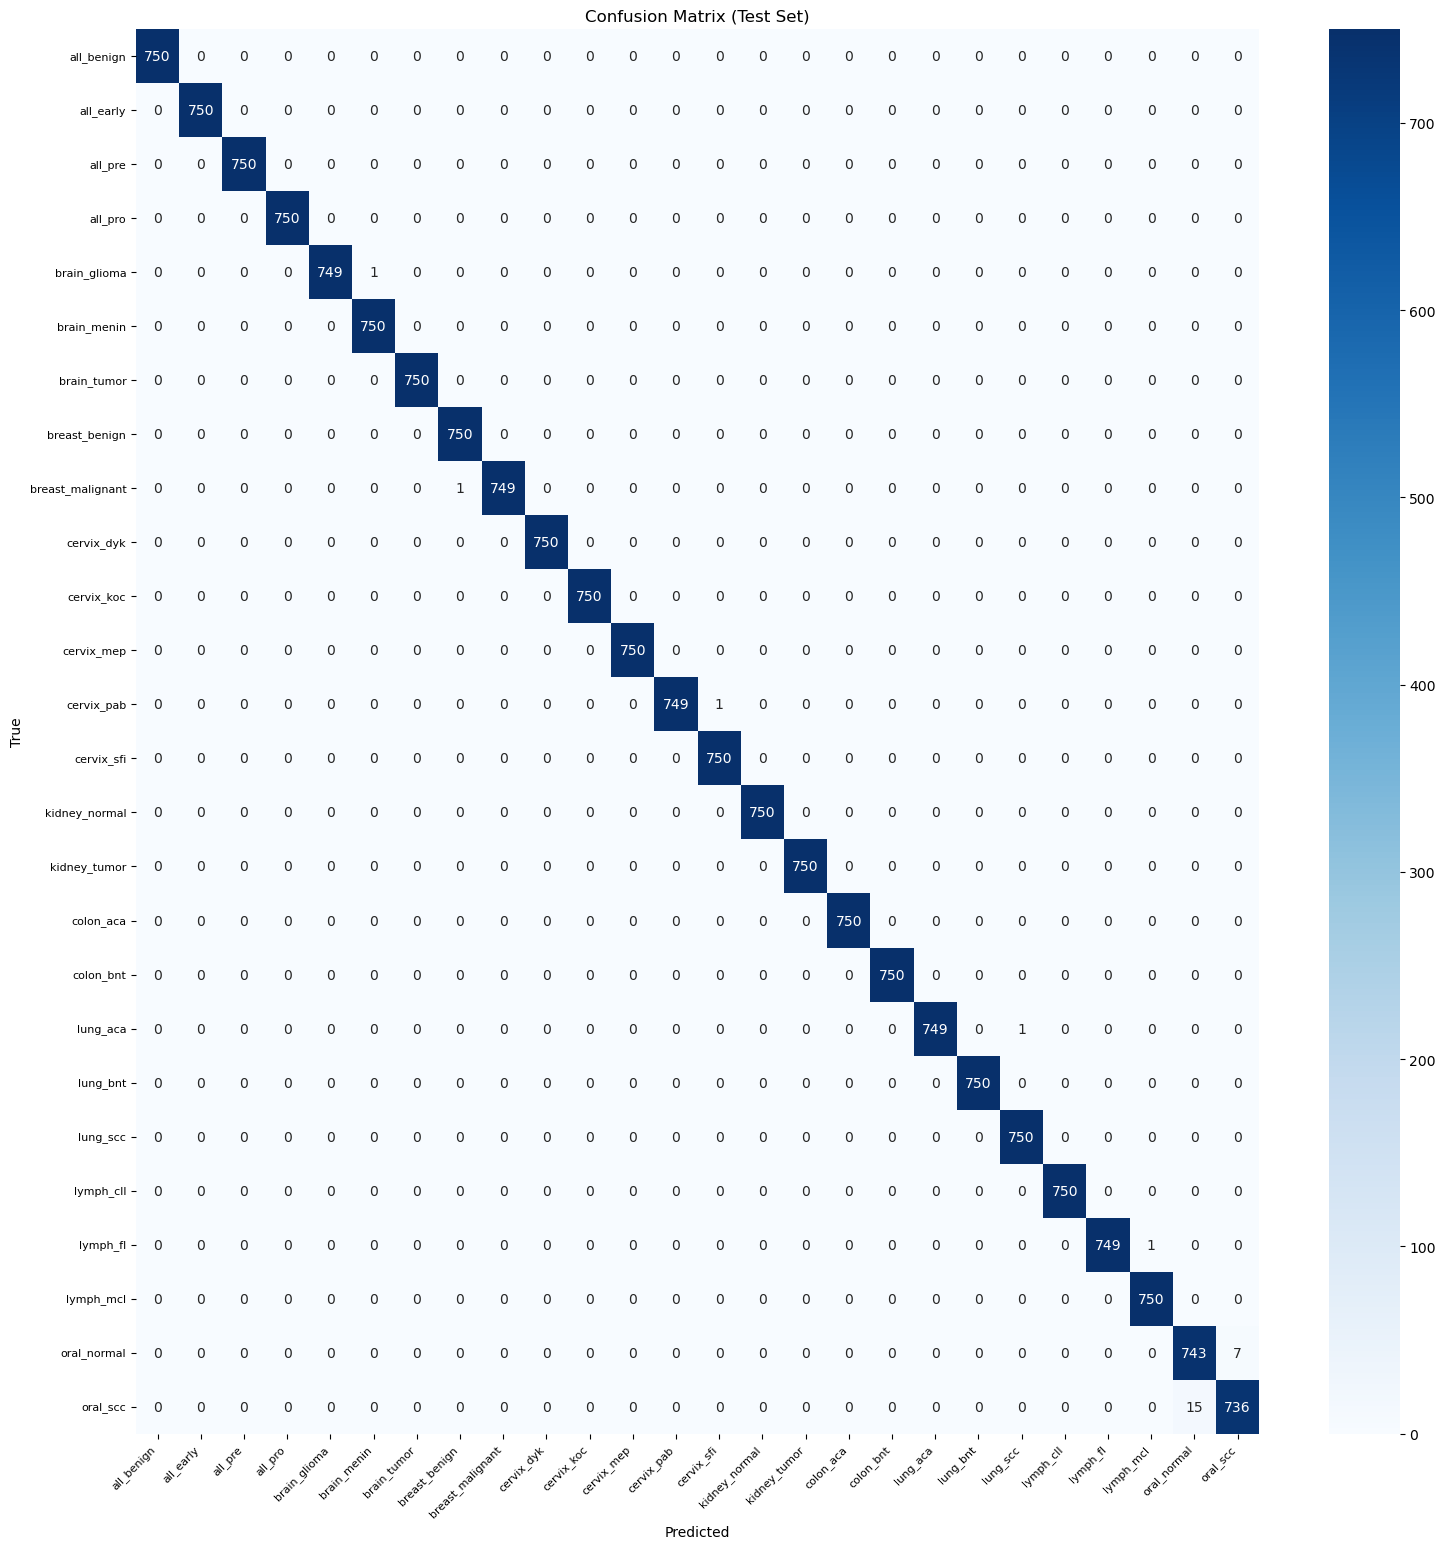

In [28]:
print("Class names:", class_names)
evaluate_on_test(model, test_loader, device, class_names=class_names)